# 의류 판매량 예측 모델
## 분석 목적
의류 판매량 예측 모델 개발

## 분석 프로세스
1. 분석 목표 정의
2. 데이터 전처리
3. EDA
4. ML 분석

## 활용 분석 모델
1. 시계열 데이터 모델링
2. Random Forest 모델링

In [48]:
# warnings 제거
import warnings
warnings.filterwarnings("ignore")


# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

# 경로 설정
import os
os.chdir("/content/drive/MyDrive/Data Analysis Projects/의류 판매량 예측 모델")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Data Analysis Projects/의류 판매량 예측 모델'

font_list[:10]


In [77]:
# 시계열 모델링 패키지
%pip install mxnet gluonts

import pandas as pd
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
from matplotlib import rc
from matplotlib.dates import date2num

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

mx.random.seed(0)
np.random.seed(0)

## 1. 분석 목표 정의

### 1-1. 시나리오

```
A 의류 회사에서는 생산량을 조절하기 위해 판매량을 예측하고자 한다.
의류의 종류에 따라 계절성을 많이 타기 때문에, 이러한 특성을 고려할 수 있는 모델링이 필요하다.
우선, 데이터 살펴보며 의류 판매량 예측을 진행한다.
```

### 1-2. 데이터 살펴보기
- 일자별 의류 판매량
- 데이터 명세

In [50]:
# 행열 뷰 수 변경
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 데이터 살펴보기
df = pd.read_excel('Data/WEAR_TS_ALL.xlsx')
df.head()

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [51]:
df.shape

(515, 1463)

---
요약
- 시계열로 나열된 데이터를 전처리 분석을 위해 변형한다.
- 모델링과 테스트를 위한 분할을 수행한다.

가공 범위 - Feature 변형: 전처리를 위한 데이터 변형</br>
데이터 분할 - Train, Validation, Test

## 2. 문제 해결 프로세스 정의

### 문제 정의
- 재고 최적화가 필요하다.
판매량을 예측할 수 있다면, 비용을 절약할 수 있을 것이다.

### 기대 효과
- 재고 관리는 의류 시장에서 큰 비용이다. 재고 관리를 최적화하면 비용을 줄일 수 있을 것이다.

### 해결 방안
1. 데이터 전처리
2. 데이터 시각화
3. 시계열 예측 모델링 - gluonts (DeepAR, Time series modeling Erorr result)
4. 랜덤 포리스트 리그래션 모델링

### 성과 측정
- 실제 판매량과 예측량의 차이

## 2. 데이터 전처리
1. 데이터 형태 화인
2. 데이터 Type 확인
3. Null 값 화인


In [52]:
# 데이터 불러오기
ts_df = pd.read_excel("Data/WEAR_TS_ALL.xlsx")
ts_df

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [53]:
ts_df.shape

(515, 1463)

In [54]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Columns: 1463 entries, SEASON to 2019-12-31 00:00:00
dtypes: float64(1461), object(2)
memory usage: 5.7+ MB


In [55]:
ts_df.dtypes

SEASON                  object
TYPE                    object
2016-01-01 00:00:00    float64
2016-01-02 00:00:00    float64
2016-01-03 00:00:00    float64
                        ...   
2019-12-27 00:00:00    float64
2019-12-28 00:00:00    float64
2019-12-29 00:00:00    float64
2019-12-30 00:00:00    float64
2019-12-31 00:00:00    float64
Length: 1463, dtype: object

In [56]:
# 이번 프로젝트는 국내 상품에 대한 분석 진행
ts_df = ts_df[ts_df['TYPE'] == '국내']

# 시즌별 판매량 예측이 목적이므로 날짜 데이터 그룹화
ts_df = ts_df.groupby('SEASON').sum()

# 날짜별 판매량을 행으로 다루기 위해 Transpose
ts_df = ts_df.T

# index를 날짜형 index로 변경
ts_df.index = pd.to_datetime(ts_df.index)
ts_df

SEASON,16SS,17SS,18SS,19SS,20SS
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-12-27,0.0,0.0,1.0,0.0,0.0
2019-12-28,0.0,0.0,3.0,0.0,2.0
2019-12-29,0.0,0.0,0.0,0.0,2.0
2019-12-30,0.0,0.0,0.0,0.0,0.0


In [57]:
# index 날짜형 확인
ts_df.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', length=1461)

In [58]:
# 각 시즌별 상품은 각 시즌에 판매되기 때문에, 시즌별 상품 통합
df = pd.concat([
                    ts_df[ts_df.index.year == 2016]['16SS'],
                    ts_df[ts_df.index.year == 2017]['17SS'],
                    ts_df[ts_df.index.year == 2018]['18SS'],
                    ts_df[ts_df.index.year == 2019]['19SS']
              ])
df = pd.DataFrame(df, columns = ['sales'])
df

,sales
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,2.0
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0
2019-12-30,0.0


## 3. 데이터 EDA

In [73]:
warnings.filterwarnings(action='ignore')


<Axes: >

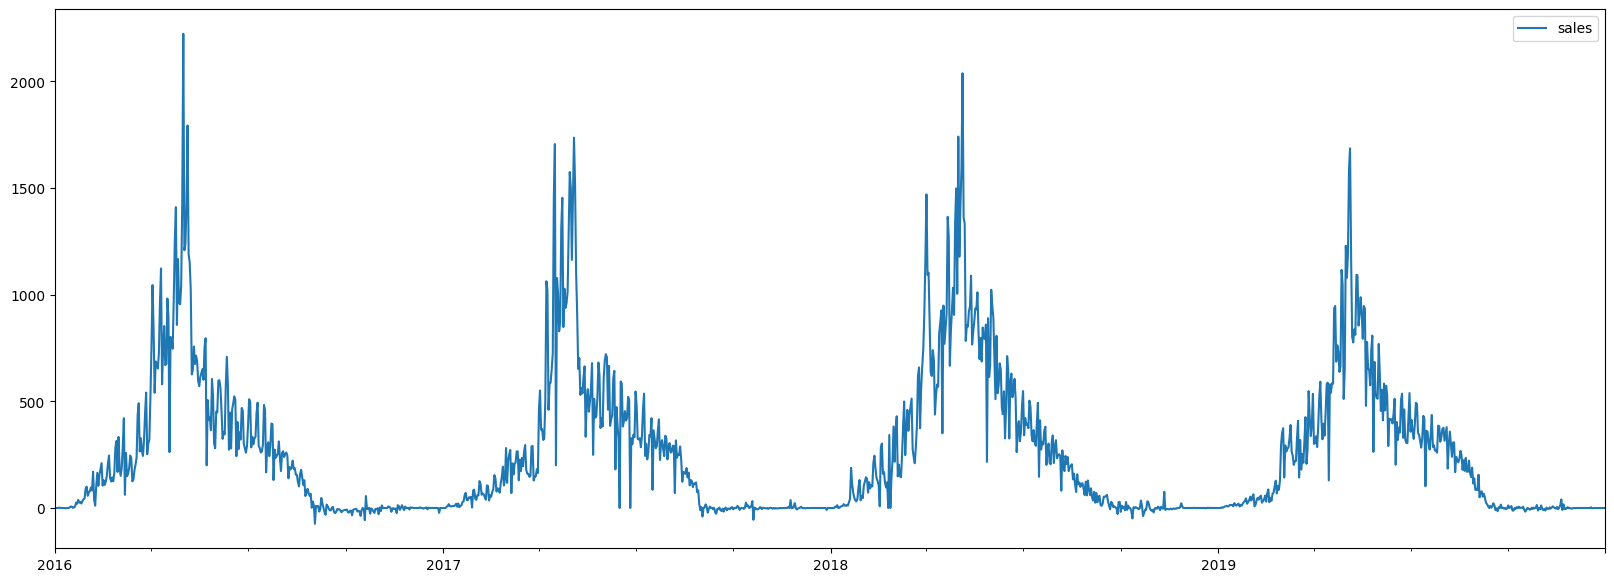

In [79]:
df.plot(figsize = (20, 7))

In [60]:
# 시스템 오류로 인해 발생한 이상치 삭제를 위해 값 치환
df[(df['sales'] <- 1000) | (df['sales'] > 2500)] = 0

<Axes: >

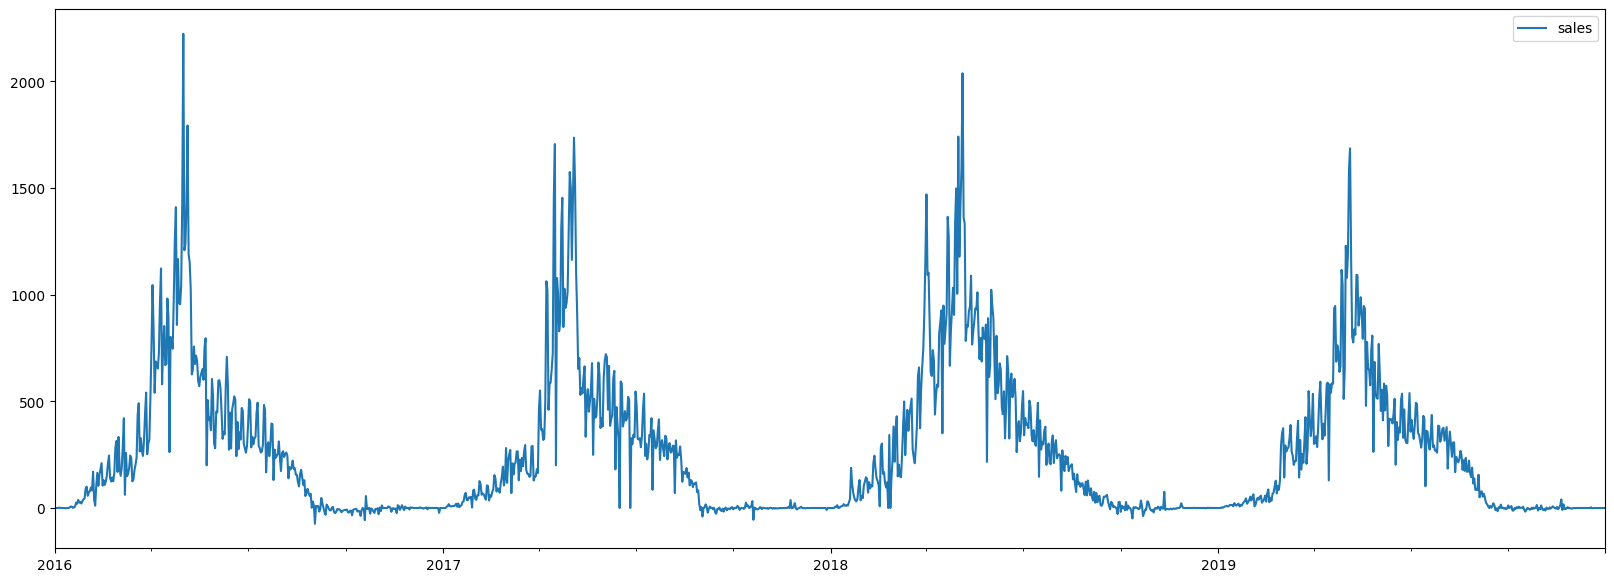

In [61]:
df.plot(figsize = (20, 7))

In [62]:
# 학습 데이터는 2019년 여름 시즌 이전까지
train_df = df[:-200]

# 테스트 데이터는 2019년 여름 시즌부터 겨울 시즌 전까지 peak 100일에 대한 예측
test_df = df[-200:-100]

<Axes: >

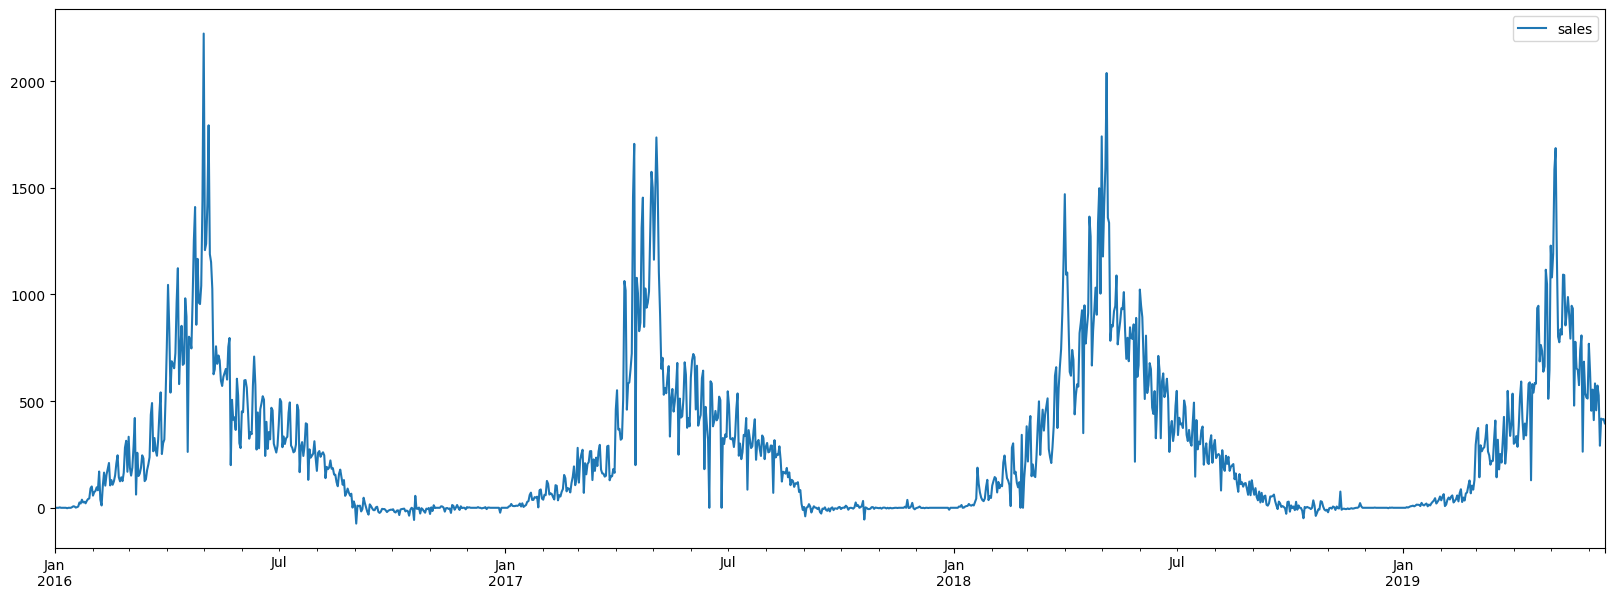

In [63]:
train_df.plot(figsize = (20, 7))

<Axes: >

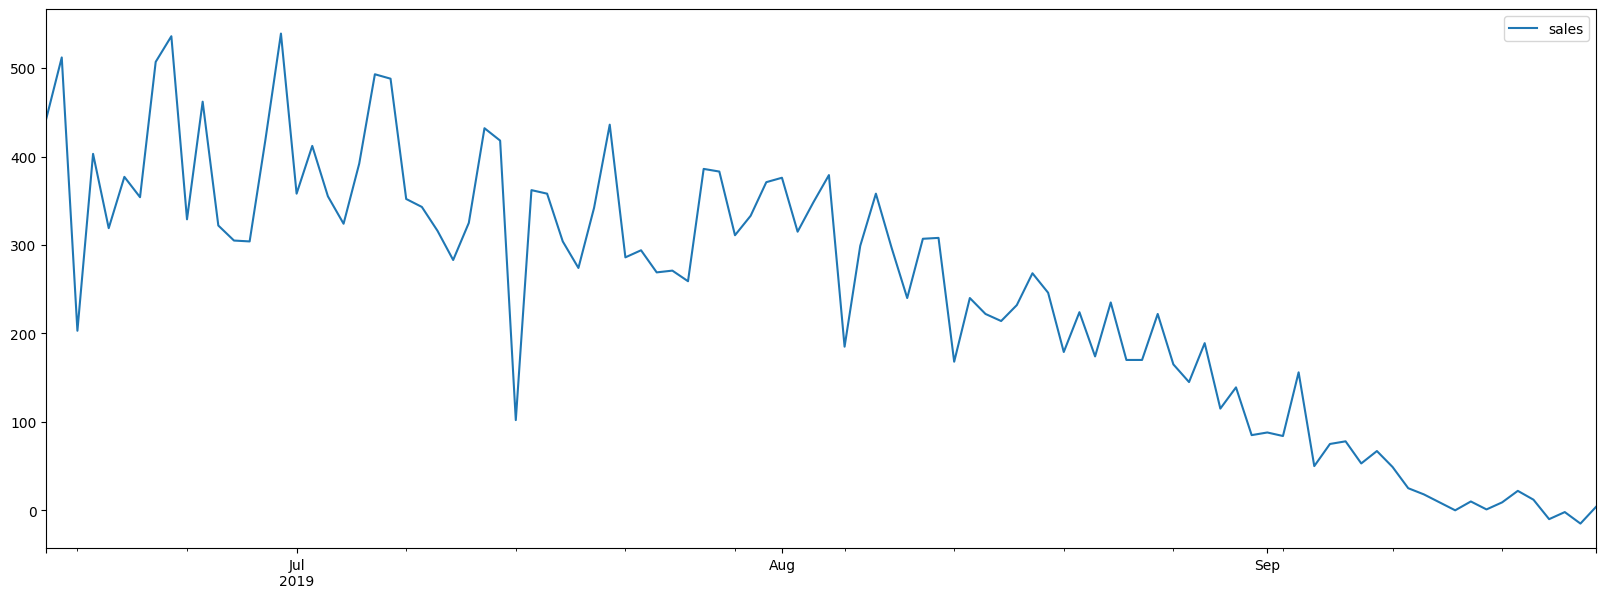

In [64]:
test_df.plot(figsize = (20, 7))

## 4. ML 분석

### 4-1. 시계열 예측 모델링
- Time series data model using DeepAR

In [65]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from pathlib import Path

In [66]:
# 함수 정의
def plot_prob_forecasts(ts_entry, forecast_entry):
    prediction_inervals = (90.0, 50.0)
    legend = ["Sales", "observations", "median prediction"] + [f'{k}% prediction interval' for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, sharex = True, sharey = False, figsize = (20,7))

    ts_entry.plot(ax = ax)
    forecast_entry.plot(prediction_inervals = prediction_inervals, color = 'g')
    plt.grid(which = 'both')
    plt.legend(legend, loc = 'upper left')
    plt.show()

In [67]:
# 학습셋 데이터
train_df.head()

,sales
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,2.0


In [68]:
# 평가셋 데이터
test_df.head()

,sales
2019-06-15,442.0
2019-06-16,512.0
2019-06-17,203.0
2019-06-18,403.0
2019-06-19,319.0


In [69]:
# 학습셋 확인
train_df.values.flatten()

array([  0.,   0.,   0., ..., 414., 416., 396.])

In [70]:
# DeepAR 알고리즘을 위해 미리 만들어둔 DataFrame을 ListDataset으로 다시 생성
train_ds = ListDataset([{FieldName.TARGET: train_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2016-01-01 00:00:00", freq = 'D')
                         }],
                        freq = 'D')

test_ds = ListDataset([{FieldName.TARGET: test_df.values.flatten(),
                        FieldName.START: pd.Timestamp("2016-01-01 00:00:00", freq = 'D')
                        }],
                        freq = 'D')

In [71]:
# 시계열 예측 알고리즘 중 가장 많이 사용하는 DeepAR
estimator = DeepAREstimator(
# 데이터의 주기(D, W, M, Y)
freq = 'D',
#
)

ValidationError: 1 validation error for DeepAREstimatorModel
prediction_length
  field required (type=value_error.missing)